## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [21]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [22]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

### Data Load

In [23]:
# 데이터 로드
Total_train = pd.read_csv('../data/Total_train_dataset_43.csv')
Total_test = pd.read_csv('../data/Total_test_dataset_43.csv')

In [24]:
# ID 열을 제외한 특성과 타겟 변수 분리
Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

### 인코딩 

In [25]:
Total_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256344 entries, 0 to 256343
Data columns (total 94 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   시술_당시_나이               256344 non-null  object 
 1   임신_시도_또는_마지막_임신_경과_연수  256344 non-null  float64
 2   배란_자극_여부               256344 non-null  int64  
 3   단일_배아_이식_여부            256344 non-null  float64
 4   착상_전_유전_검사_사용_여부       256344 non-null  float64
 5   착상_전_유전_진단_사용_여부       256344 non-null  float64
 6   남성_주_불임_원인             256344 non-null  int64  
 7   남성_부_불임_원인             256344 non-null  int64  
 8   여성_주_불임_원인             256344 non-null  int64  
 9   여성_부_불임_원인             256344 non-null  int64  
 10  부부_주_불임_원인             256344 non-null  int64  
 11  부부_부_불임_원인             256344 non-null  int64  
 12  불명확_불임_원인              256344 non-null  int64  
 13  불임_원인_-_난관_질환          256344 non-null  int64  
 14  불임_원인_-_남성_요인          256344 non-nu

In [34]:
Total_categorical_columns = [
    "시술_당시_나이",
    "난자_기증자_나이",
    "정자_기증자_나이"
]

In [35]:
# 모든 범주형 변수를 문자열로 변환
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

## Modeling

In [28]:
# 데이터 분할
Total_X_train, Total_X_test, Total_y_train, Total_y_test = train_test_split(Total_X, 
                                                                            Total_y, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=Total_y)

### Total 데이터


--- Stacking Model Performance ---
Model Accuracy: 0.7430416040882405
Model F1 Score: 0.28896804835924006
Model AUC: 0.7382239968525968


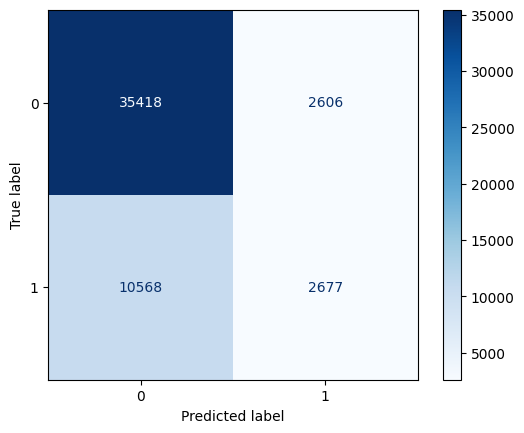

In [16]:
# 모델 초기화
lgb_model = lgb.LGBMClassifier(
    n_estimators=7655,
    num_leaves=2855,
    max_depth=5,
    learning_rate=0.16281911161693016,
    min_child_samples=460,
    subsample=0.38886888090131794,
    reg_alpha=36.93967560025368,
    reg_lambda=96.03211423886586,
    metric='auc',
    objective='binary',
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=6377,
    learning_rate=0.09743491488399733,
    max_depth=414,
    alpha=2.5680787908055764,
    gamma=1.6904727699858604,
    reg_alpha=33.97190639119776,
    reg_lambda=93.11438571710458,
    subsample=0.7198107387781483,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    verbosity=0
)

cat_model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    l2_leaf_reg=3.0,
    random_strength=1.0,
    bagging_temperature=1.0,
    border_count=128,
    thread_count=-1,
    random_state=42,
    logging_level='Silent',
    boosting_type='Plain'
)

# 모델 학습
lgb_model.fit(Total_X_train, Total_y_train)
xgb_model.fit(Total_X_train, Total_y_train)
cat_model.fit(Total_X_train, Total_y_train)

# 예측
lgb_pred = lgb_model.predict_proba(Total_X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(Total_X_test)[:, 1]
cat_pred = cat_model.predict_proba(Total_X_test)[:, 1]

# 스태킹을 위한 예측 결과 결합
stacked_predictions = np.column_stack((lgb_pred, xgb_pred, cat_pred))

# 메타 모델 초기화 및 학습
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_predictions, Total_y_test)

# 메타 모델 예측
meta_pred = meta_model.predict(stacked_predictions)
meta_pred_proba = meta_model.predict_proba(stacked_predictions)[:, 1]

# 평가
accuracy = accuracy_score(Total_y_test, meta_pred)
f1 = f1_score(Total_y_test, meta_pred)
auc = roc_auc_score(Total_y_test, meta_pred_proba)
cm = confusion_matrix(Total_y_test, meta_pred)

# 결과 출력
print()
print("--- Stacking Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=meta_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC xx

## 제출

In [30]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# 데이터 로드
Total_train = pd.read_csv('../data/Total_train_dataset_43.csv')
Total_test = pd.read_csv('../data/Total_test_dataset_43.csv')

# ID 열을 제외한 특성과 타겟 변수 분리
Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

# 테스트 데이터의 ID 열을 제외한 특성 분리
Total_X_test = Total_test.drop(['ID'], axis=1)
Total_y_test = Total_test['ID']

# 모든 범주형 변수를 문자열로 변환
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

# 모델 초기화
lgb_model = lgb.LGBMClassifier(
    n_estimators=7655,
    num_leaves=2855,
    max_depth=5,
    learning_rate=0.16281911161693016,
    min_child_samples=460,
    subsample=0.38886888090131794,
    reg_alpha=36.93967560025368,
    reg_lambda=96.03211423886586,
    metric='auc',
    objective='binary',
    random_state=42,
    boosting_type='gbdt',
    verbose=-1
)

xgb_model = xgb.XGBClassifier(
    n_estimators=6377,
    learning_rate=0.09743491488399733,
    max_depth=414,
    alpha=2.5680787908055764,
    gamma=1.6904727699858604,
    reg_alpha=33.97190639119776,
    reg_lambda=93.11438571710458,
    subsample=0.7198107387781483,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    random_state=42,
    verbosity=0
)

cat_model = CatBoostClassifier(
    iterations=3000,
    learning_rate=0.1,
    depth=10,
    l2_leaf_reg=3.0,
    random_strength=1.0,
    bagging_temperature=1.0,
    border_count=128,
    thread_count=-1,
    random_state=42,
    logging_level='Silent',
    boosting_type='Plain'
)

# 모델 학습
lgb_model.fit(Total_X, Total_y)
xgb_model.fit(Total_X, Total_y)
cat_model.fit(Total_X, Total_y)

# 예측
lgb_pred = lgb_model.predict_proba(Total_X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(Total_X_test)[:, 1]
cat_pred = cat_model.predict_proba(Total_X_test)[:, 1]

# 스태킹을 위한 예측 결과 결합
stacked_predictions = np.column_stack((lgb_pred, xgb_pred, cat_pred))

# 메타 모델 초기화 및 학습
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_predictions, Total_y_test)

# 메타 모델 예측
meta_pred_proba = meta_model.predict_proba(stacked_predictions)[:, 1]

# 제출 파일 생성
submission = pd.DataFrame({'ID': Total_test['ID'], '임신_성공_여부': meta_pred_proba})

# 제출 파일 저장
submission.to_csv('../submission/code43_all_stacking.csv', index=False, encoding='utf-8')

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: 시술_당시_나이: object, 난자_기증자_나이: object, 정자_기증자_나이: object

In [36]:
# 데이터 로드
Total_train = pd.read_csv('../data/Total_train_dataset_43.csv')
Total_test = pd.read_csv('../data/Total_test_dataset_43.csv')

# ID 열을 제외한 특성과 타겟 변수 분리
Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

# 테스트 데이터의 ID 열을 제외한 특성 분리
Total_X_test = Total_test.drop(['ID'], axis=1)
Total_y_test = Total_test['ID']

# 모든 범주형 변수를 문자열로 변환
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

In [37]:
# 예측
lgb_pred = lgb_model.predict_proba(Total_X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(Total_X_test)[:, 1]
cat_pred = cat_model.predict_proba(Total_X_test)[:, 1]

# 스태킹을 위한 예측 결과 결합
stacked_predictions = np.column_stack((lgb_pred, xgb_pred, cat_pred))

# 메타 모델 초기화 및 학습
meta_model = LogisticRegression(random_state=42)
meta_model.fit(stacked_predictions, Total_y_test)

# 메타 모델 예측
meta_pred_proba = meta_model.predict_proba(stacked_predictions)[:, 1]

# 제출 파일 생성
submission = pd.DataFrame({'ID': Total_test['ID'], '임신_성공_여부': meta_pred_proba})

# 제출 파일 저장
submission.to_csv('../submission/code43_all_stacking.csv', index=False, encoding='utf-8')

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: 시술_당시_나이: object, 난자_기증자_나이: object, 정자_기증자_나이: object

----

.